## Limpe seus dados

In [56]:
library(data.table)
library(forecast)
library(zoo)

### Lidando com dados ausente

Dados ausentes em séries temporais são bastantes comuns visto que a carga de amostragem longitudinal é bastante pesada. Dessa forma, se desenvolveu metodos para lidar com dados ausente em series temporais no quais são:

1. Imputação
2. Interpolação
3. Exclusão dos tempos afetados

#### Preparação

Vamos gerar conjunto de dados contendo dados nulos, usando a taxa de desemprego dos estados unidos. Removendo aleatoriamente os dados e removendo o mesmo com maior indice de desemprego

In [57]:
unrate = fread('dataset/UNRATE.csv')
head(x = unrate, n = 5)

DATE,UNRATE
<IDate>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [58]:
unrate[, DATE:= as.Date(DATE)]
setkey(unrate, DATE)

In [59]:
# Gerando um conjunto de dados onde estão aleatoriamente ausentes
set.seed(1)
rand.unrate.idx = sample(1:nrow(x = unrate), .1*nrow(unrate))
rand.unrate.idx

[1] 836 679 129 509 471 299 270 187 307 597 277 494 330 775 591 725  37 105 729
[20] 485 677 802 382 601 801 326 832 554 422 111 404 532 506 556 343 582 121  40
[39] 684 537 375 248 198 378  39 435 390 280 672 526 642  45 402  22 718 742 193
[58] 371 499 104 819 767 492 616 615 465 525 826 176 345 110  84  29 141 252 733
[77] 620 304 545 557 661 287 614 145

In [60]:
rand.unrate = unrate[-rand.unrate.idx]

In [61]:
# Removendo dados com maior prob de NA quando o desempredo é alto

high.unrate.idx = which(unrate$UNRATE > 8)
num.to.select   = .2 * length(high.unrate.idx)

high.unrate.idx = sample(high.unrate.idx, )

bias.unrate = unrate[-high.unrate.idx]

In [62]:
all.date = seq(from = unrate$DATE[1], to = tail(x = unrate$DATE, n = 1), by = 'month')


rand.unrate = rand.unrate[J(all.date), roll=0]
bias.unrate = bias.unrate[J(all.date), roll=0]

rand.unrate[, rpt:=is.na(UNRATE)]

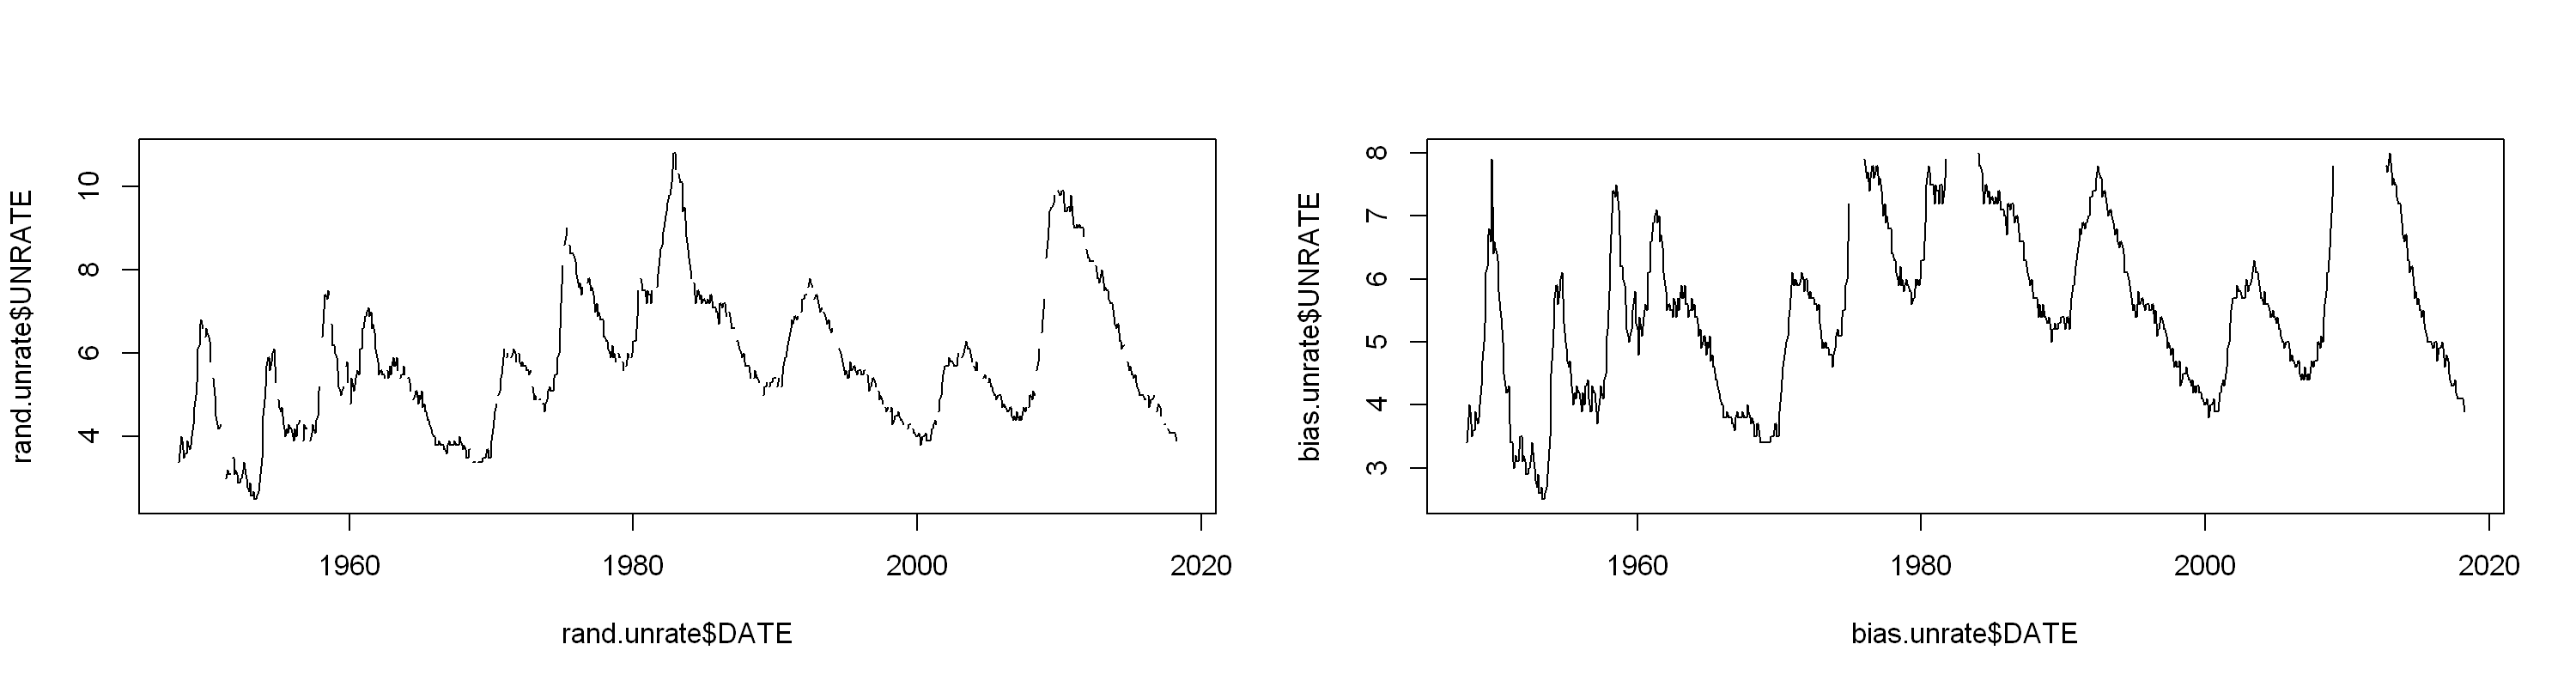

In [63]:
par(mfrow = c(1, 2), bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
plot(rand.unrate$DATE, rand.unrate$UNRATE, type = 'l')
plot(bias.unrate$DATE, bias.unrate$UNRATE, type = 'l')

### Métodos de imputação

#### Foward fill
Uma das formas mais simples de preencher os valores ausente é transferindo o ultimo valor conhecido para o valor ausente anterior

In [64]:
rand.unrate[, imputacao.ff := na.locf(UNRATE)]
bias.unrate[, imputacao.ff := na.locf(UNRATE)]

NULL

NULL

NULL

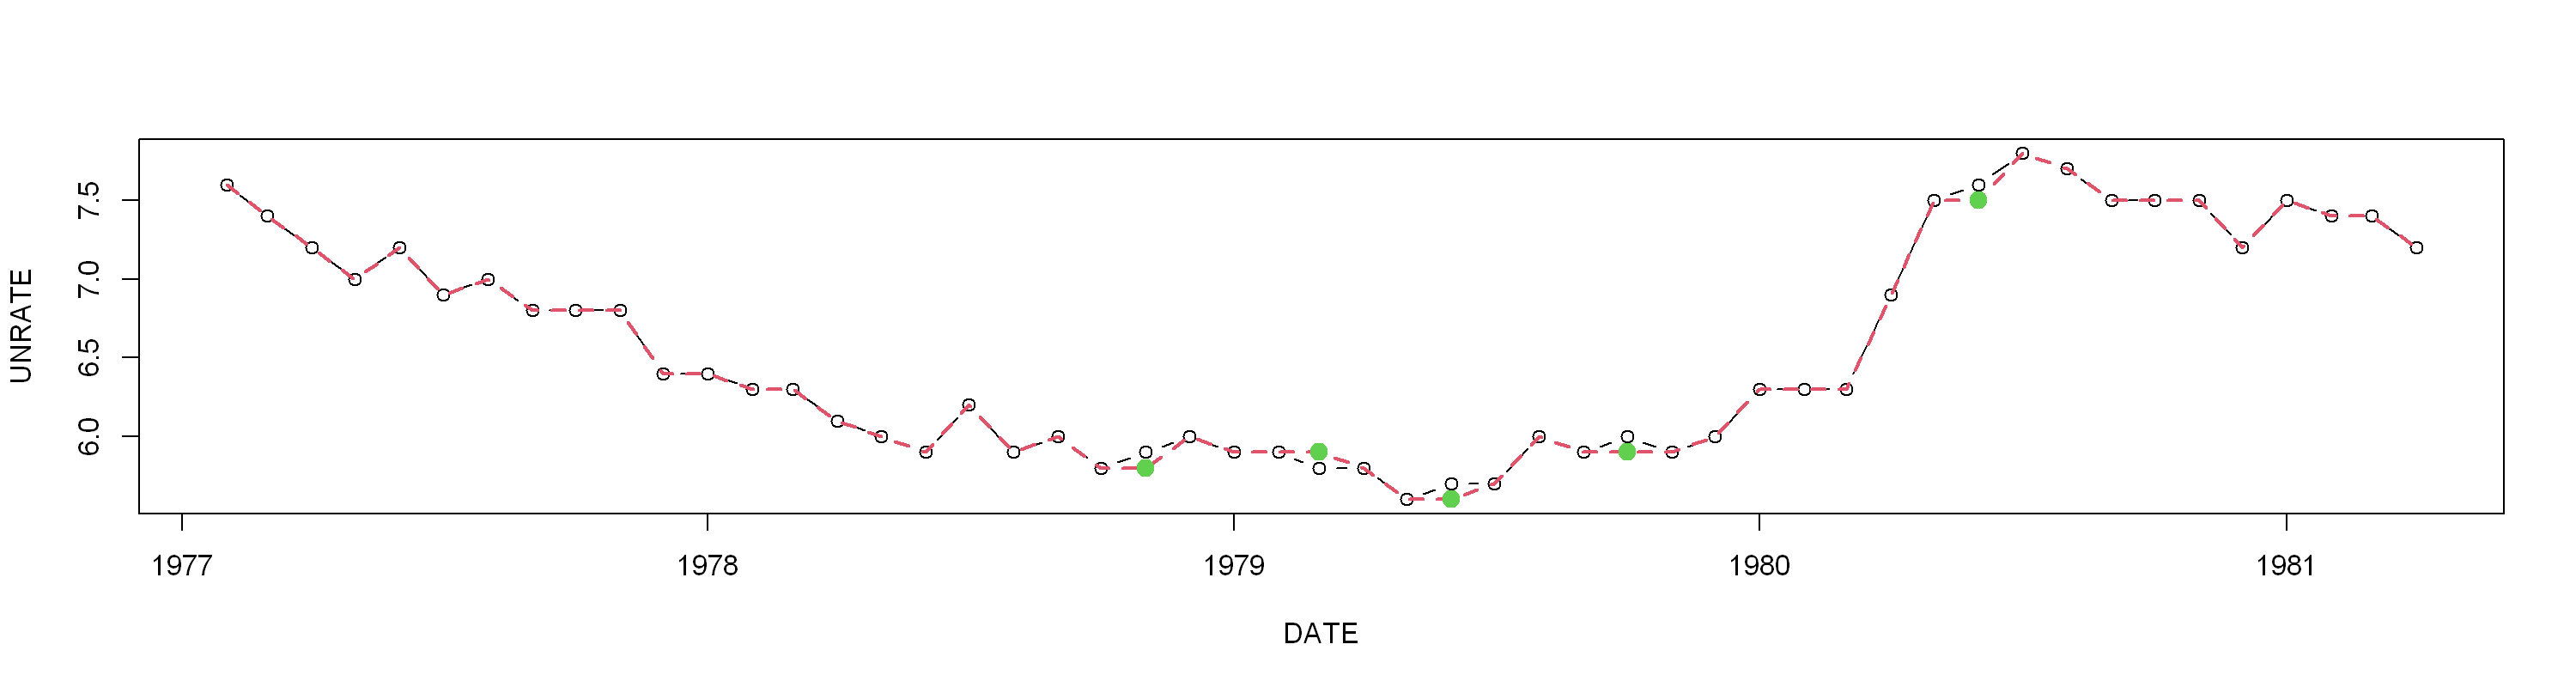

In [65]:
par(bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
unrate[350:400,
    plot(DATE, UNRATE, type = 'b', lwd=1, col=1),
]
rand.unrate[350:400,
    lines(DATE, imputacao.ff, col=2, lwd=2, lty=2)
]
rand.unrate[
    350:400
][rpt==TRUE, points(DATE, imputacao.ff, col=3, pch=20, cex=2)]


> Os pontos ventes são os valores imputados

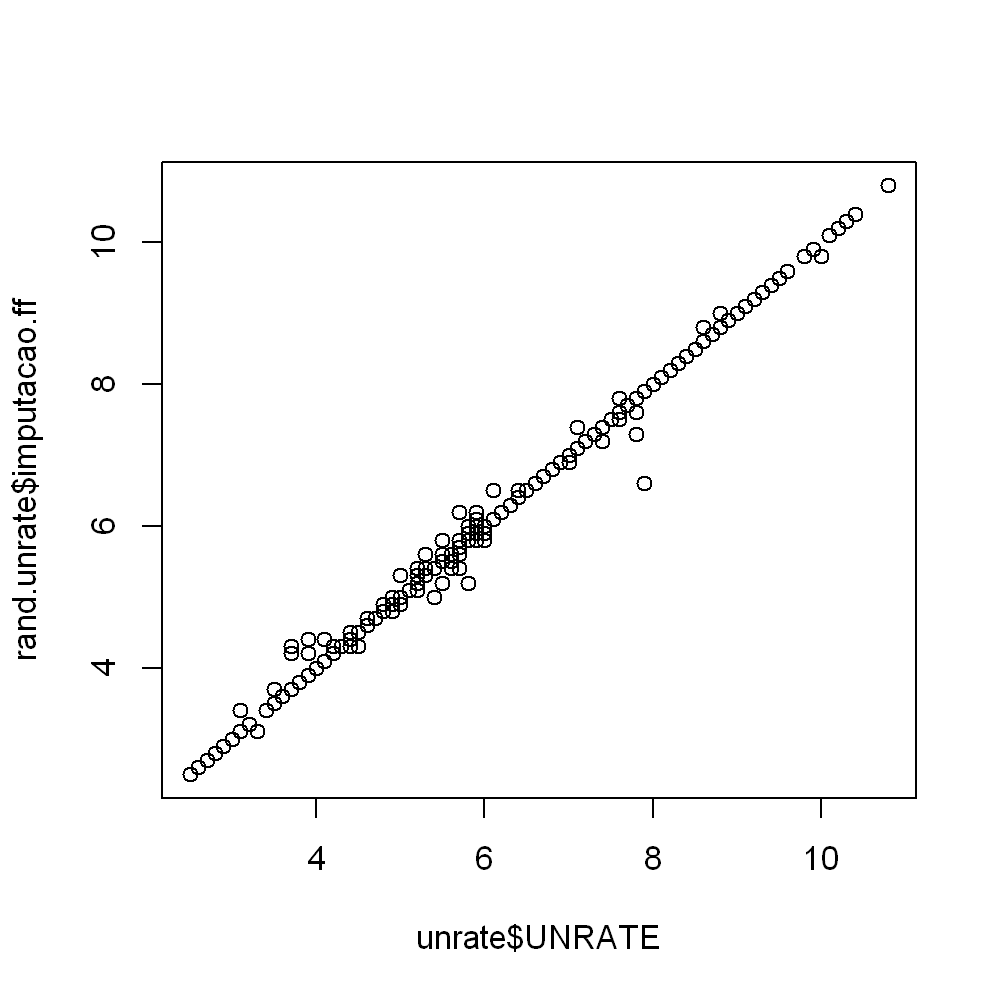

In [66]:
par(bg = 'white')
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plot(unrate$UNRATE, rand.unrate$imputacao.ff)

> Voce pode usar o forward fill para pegar valores do passados e progeta-los no futoro mas isso é o **lookhead**
> #### LOOKHEAD
> Lookahead bias é quando, sem querer, você usa dados de períodos futuros para treinar ou validar um modelo para períodos > passados.
>
> Exemplo: ao calcular a média móvel de janeiro usando dados de fevereiro, você está “espiando” o futuro
>
> **SO USE SE NÃO QUISER TREINAR UM MODELO**

> **Foward fill** apresenta muitas vantagem: não é computacionamente caro e apresentea um desempenho decente em relação a imputação

#### Média Movel
Motivos para usar a media movel ao inves do forward fill:
1. Se os dados forem muito ruidosos

In [67]:
rand.unrate[, imputacao.mm.sem.lookakead := rollapply( c(NA, NA, UNRATE), 3 ,
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
    )]

bias.unrate[, imputacao.mm.sem.lookakead := rollapply( c(NA, NA, UNRATE), 3 ,
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)]

> Nãp precisa ser necessariamente a media aritimetca. As **media moveis exponenciais** poderadas forneceriam mais peso aos dados recentes do que aos dados passados.
> Media geometrica pode ser de grande serventia para series temporais com alta correlação serial e nos casos em que os valores se combinam ao longo do tempo.

NULL

NULL

NULL

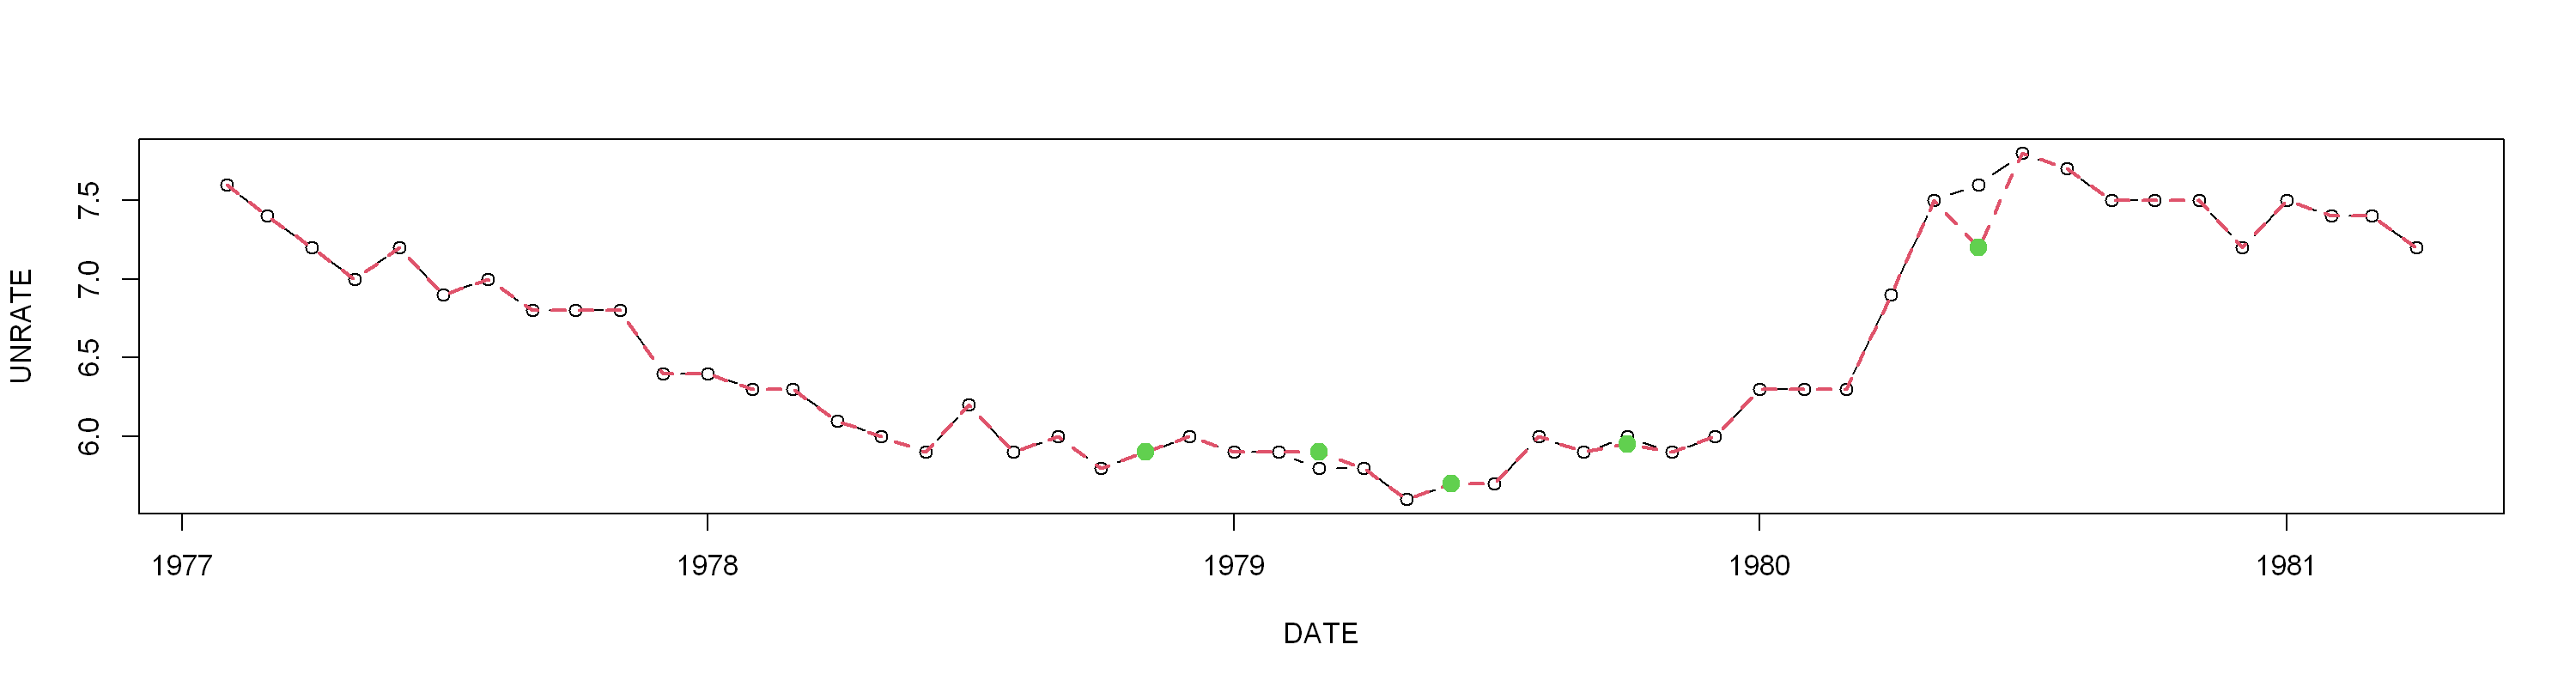

In [68]:
par(bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
unrate[350:400,
    plot(DATE, UNRATE, type = 'b', lwd=1, col=1),
]
rand.unrate[350:400,
    lines(DATE, imputacao.mm.sem.lookakead, col=2, lwd=2, lty=2)
]
rand.unrate[
    350:400
][rpt==TRUE, points(DATE, imputacao.mm.sem.lookakead, col=3, pch=20, cex=2)]


#### Interpolação


In [69]:
# interpolação linear

rand.unrate[, imputacao.inter.linear := na.approx(UNRATE)]
bias.unrate[, imputacao.inter.linear := na.approx(UNRATE)]

#Interpolação polinomial
rand.unrate[, imputacao.inter.poli := na.spline(UNRATE)]
bias.unrate[, imputacao.inter.poli := na.spline(UNRATE)]

NULL

NULL

NULL

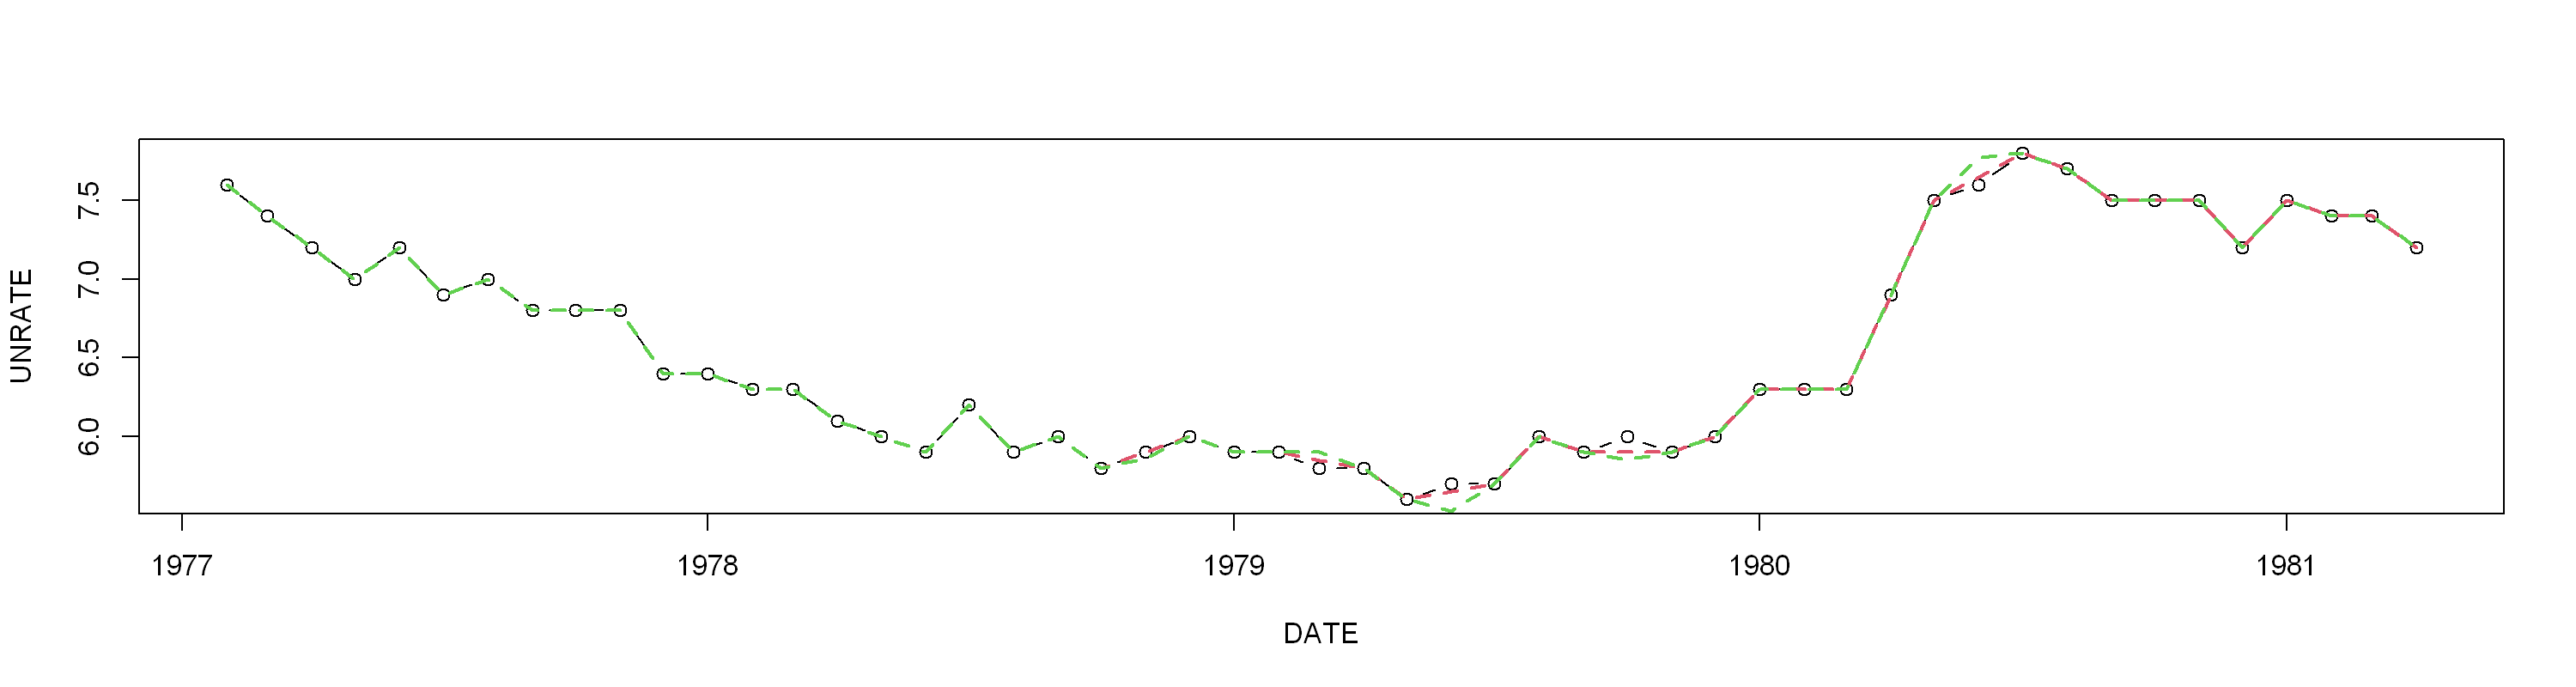

In [70]:
par(bg = 'white')
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)

use.idx = 350:400
unrate[use.idx,
    plot(DATE, UNRATE, type = 'b', lwd=1, col=1),
]
rand.unrate[use.idx,
    lines(DATE, imputacao.inter.linear , col=2, lwd=2, lty=2)
]
rand.unrate[use.idx,
    lines(DATE, imputacao.inter.poli , col=3, lwd=2, lty=2)
 ]

> Situações em que inter linear não é nem um pouco oportuna , por exemplo dados ausentes de precipitação voce não deve extrapolar linearmente os dias conhecidos ; como sabemos, não é assim que as chuvas se comportam.

#### Comparação geral

In [71]:

rand.unrate[, 
    lapply(.SD, 
        function(x){mean((x-rand.unrate$UNRATE)^2,na.rm = TRUE)}), 
    .SDcols = c('UNRATE', 'imputacao.ff', 'imputacao.mm.sem.lookakead','imputacao.inter.linear', 'imputacao.inter.poli')
]


UNRATE,imputacao.ff,imputacao.mm.sem.lookakead,imputacao.inter.linear,imputacao.inter.poli
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,2.594937e-34


In [72]:
bias.unrate[, 
    lapply(.SD, 
        function(x){mean((x-rand.unrate$UNRATE)^2,na.rm = TRUE)}), 
    .SDcols = c('UNRATE', 'imputacao.ff', 'imputacao.mm.sem.lookakead','imputacao.inter.linear', 'imputacao.inter.poli')
]

UNRATE,imputacao.ff,imputacao.mm.sem.lookakead,imputacao.inter.linear,imputacao.inter.poli
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2373947,0.005036232,0.2220384,0.02481059


### Dowsampling e upsampling

É possivel alterar a frequencia dos timestamps em sua coleta de dados, isso se chama up|downsampling ou tecnicas de aumento ou redução da frequencia do timestamp. Isso visto que os dados de serie temporal muitas vezes não terão a mesma frequencia

#### Downsampling

Sempre que voce reduz a frequencia dos dados esta reduzindo a resolução. Isso é feito muitas vezes nos seguintes casos.
* Resolução original dos dados não é adequada
* Foque uma parte especifica de um ciclo sazonal
* Compare os dados em um frequencia menor

#### Upsampling

## Suavização de dados

In [75]:
frequency(unrate)

[1] 1